In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
import numpy as np

### Récupération des données

In [2]:
crypto_scraper = CryptoScraper()
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.head()

(3762, 7)


,Date,Open,High,Low,Close,Adj,Volume
0,"Jan 3, 2025","96,890.01","97,248.90","96,042.52","97,046.12","97,046.12","36,629,499,904"
1,"Jan 2, 2025","94,416.29","97,739.82","94,201.57","96,886.88","96,886.88","46,009,564,411"
2,"Jan 1, 2025","93,425.10","94,929.87","92,788.13","94,419.76","94,419.76","24,519,888,919"
3,"Dec 31, 2024","92,643.25","96,090.60","91,914.03","93,429.20","93,429.20","43,625,106,843"
4,"Dec 30, 2024","93,527.20","94,903.32","91,317.13","92,643.21","92,643.21","56,188,003,691"


#### Création des time series

In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
log_returns = ts_creator.create_log_return_time_series()
volatility = ts_creator.create_volatility_time_series()

bitcoin_data["Log Returns"] = log_returns
bitcoin_data["Volatility"] = volatility

print(bitcoin_data.isna().sum())
bitcoin_data.head(35)

Date           0
Open           0
High           0
Low            0
Close          0
Adj            0
Volume         0
Log Returns    0
Volatility     0
dtype: int64


,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3761,2014-09-17,465.86,468.17,452.42,457.33,457.33,"21,056,800",0.000000,0.000000
3760,2014-09-18,456.86,456.86,413.10,424.44,424.44,"34,483,200",-0.074635,0.000000
3759,2014-09-19,424.10,427.83,384.53,394.80,394.80,"37,919,700",-0.072391,0.000000
3758,2014-09-20,394.67,423.30,389.88,408.90,408.90,"36,863,600",0.035091,0.000000
3757,2014-09-21,408.08,412.43,393.18,398.82,398.82,"26,580,100",-0.024960,0.000000
3756,2014-09-22,399.10,406.92,397.13,402.15,402.15,"24,127,600",0.008315,0.000000
3755,2014-09-23,402.09,441.56,396.20,435.79,435.79,"45,099,500",0.080335,0.000000
3754,2014-09-24,435.75,436.11,421.13,423.20,423.20,"30,627,700",-0.029316,0.000000
3753,2014-09-25,423.16,423.52,409.47,411.57,411.57,"26,814,400",-0.027866,0.000000
3752,2014-09-26,411.43,414.94,400.01,404.42,404.42,"21,460,800",-0.017525,0.000000


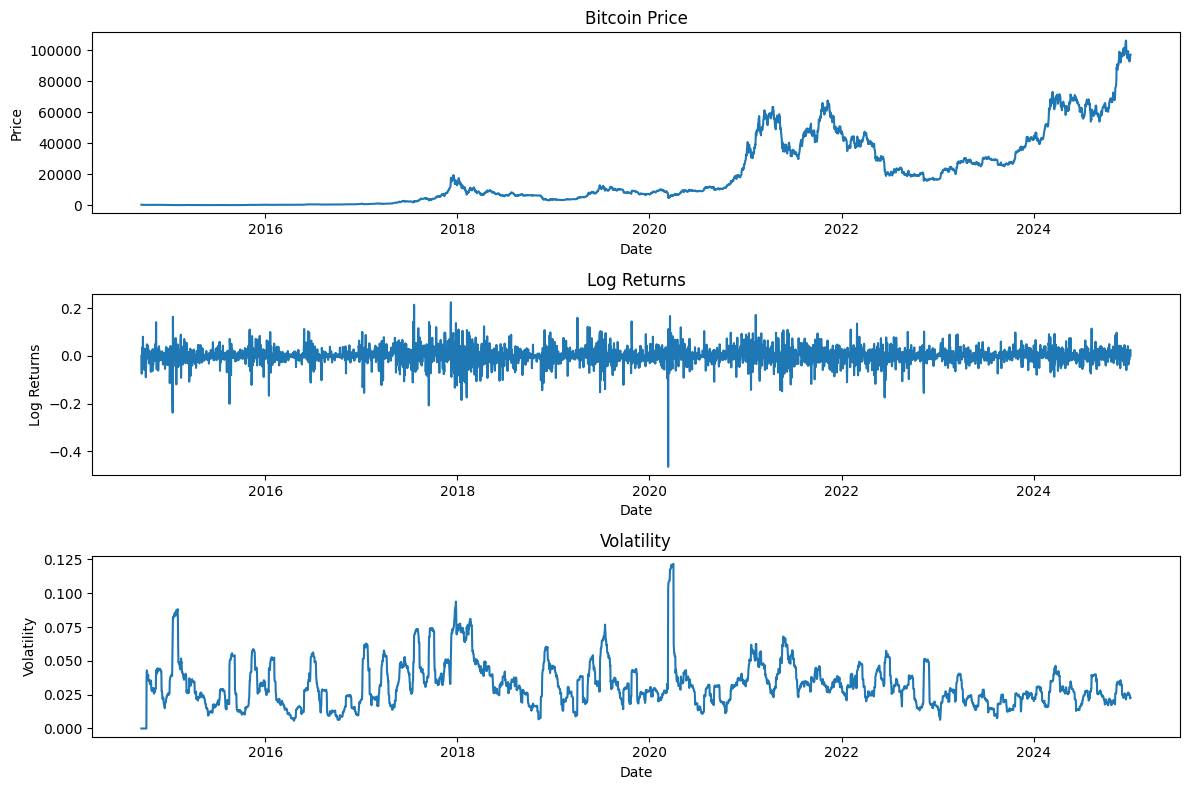

In [5]:
# sort the data by descending date
bitcoin_data = bitcoin_data.sort_values(by="Date", ascending=True)

# plotting time series by date
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Close"])
ax[0].set_title("Bitcoin Price")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")

ax[1].plot(bitcoin_data["Date"], bitcoin_data["Log Returns"])
ax[1].set_title("Log Returns")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Returns")

ax[2].plot(bitcoin_data["Date"], bitcoin_data["Volatility"])
ax[2].set_title("Volatility")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Volatility")



plt.tight_layout()
plt.show()

### Modèle GARCH

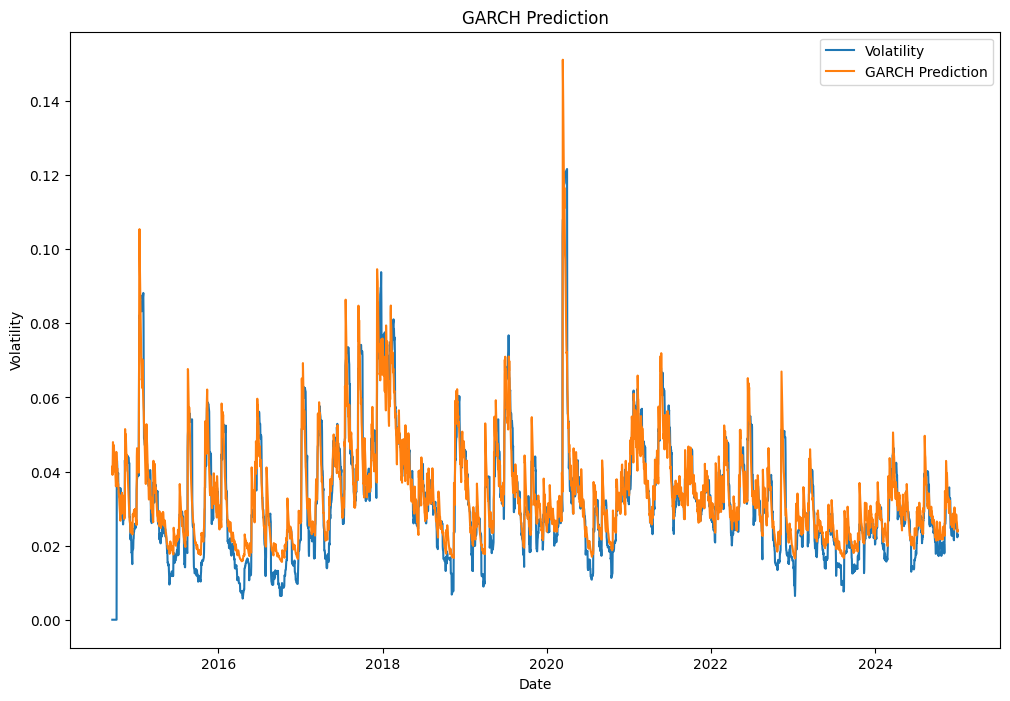

In [6]:
garch_prediction = ts_creator.compute_garch_forecast(log_returns=log_returns)


# plot the GARCH forecast
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(bitcoin_data["Date"], bitcoin_data["Volatility"], label="Volatility")
ax.plot(bitcoin_data["Date"], garch_prediction, label="GARCH Prediction")
ax.set_title("GARCH Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()


### Récupération des données d'entrainement

In [7]:
features = ts_creator.create_time_series_for_NN_training()
print(features.shape)
features.head(25)

(3733, 6)


,Log Returns,Volatility,GARCH Volatility,Volatility Weekly,Volatility Monthly,Date
3732,-0.031418,0.035361,0.033725,0.037340,0.012887,2014-10-16
3731,0.003132,0.035237,0.033730,0.036831,0.014061,2014-10-17
3730,0.019815,0.035488,0.032061,0.036504,0.015244,2014-10-18
3729,-0.004840,0.033069,0.031042,0.035657,0.016347,2014-10-19
3728,-0.017349,0.033304,0.029647,0.034755,0.017457,2014-10-20
3727,0.009437,0.032699,0.028924,0.034341,0.018547,2014-10-21
3726,-0.008627,0.032699,0.027724,0.033980,0.019637,2014-10-22
3725,-0.066747,0.035521,0.026717,0.034003,0.020821,2014-10-23
3724,-0.000195,0.034305,0.033532,0.033869,0.021964,2014-10-24
3723,-0.031408,0.028677,0.031881,0.032896,0.022920,2014-10-25


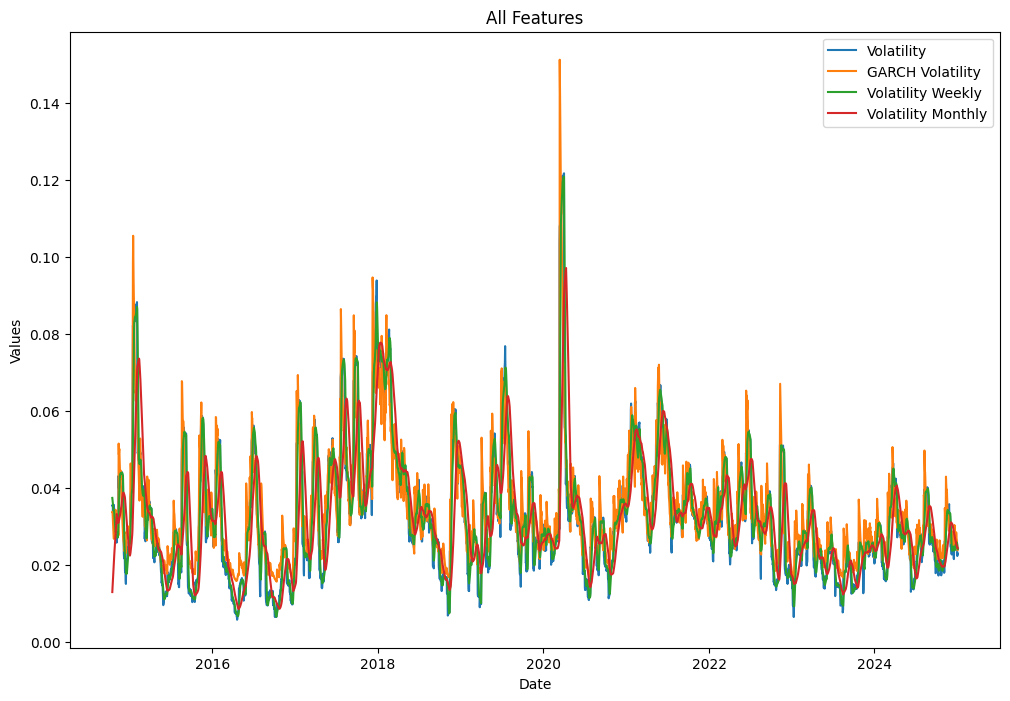

MSE between Volatility and GARCH Volatility: 4.367813163254648e-05
MAPE between Volatility and GARCH Volatility: 0.19365869960872253


In [8]:
# plot all features on the same graph
plt.figure(figsize=(12, 8))

plt.plot(features["Date"], features["Volatility"], label="Volatility")
plt.plot(features["Date"], features["GARCH Volatility"], label="GARCH Volatility")
plt.plot(features["Date"], features["Volatility Weekly"], label="Volatility Weekly")
plt.plot(features["Date"], features["Volatility Monthly"], label="Volatility Monthly")

plt.title("All Features")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

#mse between the volatility and the GARCH volatility
mse = ((features["Volatility"] - features["GARCH Volatility"]) ** 2).mean()
print(f"MSE between Volatility and GARCH Volatility: {mse}")

# mape between the volatility and the GARCH volatility
mape = (abs(features["Volatility"] - features["GARCH Volatility"]) / features["Volatility"]).mean()
print(f"MAPE between Volatility and GARCH Volatility: {mape}")

In [ ]:
from crypto_volatility_lab.modeling import LSTMPipeline

data = features[["Volatility", "GARCH Volatility", "Volatility Weekly", "Volatility Monthly"]].values
pipeline = LSTMPipeline(window_size=5, forecast_horizon=1, in_sample_size=20, 
                        out_sample_size=2, lstm_units=5, n_jobs=7, epochs=1, batch_size=32)

results = pipeline.run(data)

Training progress:   8%|▊         | 301/3705 [03:04<28:53,  1.96it/s]  c:\Users\emmae\OneDrive\Documents\M2\Projet Finance\crypto-volatility-lab\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Training progress:  26%|██▌       | 966/3705 [11:32<40:04,  1.14it/s]  